# Customer Segmentation Using RFM Analysis.

In [243]:
#Get all packages needed
import pandas as pd
import numpy as np
import datetime
from pendulum.period import precise_diff
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score,roc_auc_score,ConfusionMatrixDisplay,classification_report,recall_score
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler,OneHotEncoder,OrdinalEncoder
from imblearn.over_sampling import RandomOverSampler
import dateutil
import matplotlib.pyplot as plt
import plotly.express as px
import warnings
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
import math as ma
warnings.filterwarnings("ignore")

In [244]:
xls = pd.ExcelFile('KPMG-DATA.xlsx')
df = pd.read_excel(xls, 'CustomerDemographic',skiprows=[0])
customer_address = pd.read_excel(xls, 'CustomerAddress', skiprows=[0])
transactions = pd.read_excel(xls, 'Transactions',skiprows=[0])
df_new_customers = pd.read_excel(xls, 'NewCustomerList',skiprows=[0])

In [245]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4000 entries, 0 to 3999
Data columns (total 13 columns):
 #   Column                               Non-Null Count  Dtype         
---  ------                               --------------  -----         
 0   customer_id                          4000 non-null   int64         
 1   first_name                           4000 non-null   object        
 2   last_name                            3875 non-null   object        
 3   gender                               4000 non-null   object        
 4   past_3_years_bike_related_purchases  4000 non-null   int64         
 5   DOB                                  3913 non-null   datetime64[ns]
 6   job_title                            3494 non-null   object        
 7   job_industry_category                3344 non-null   object        
 8   wealth_segment                       4000 non-null   object        
 9   deceased_indicator                   4000 non-null   object        
 10  default     

In [246]:
customer_address.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3999 entries, 0 to 3998
Data columns (total 6 columns):
 #   Column              Non-Null Count  Dtype 
---  ------              --------------  ----- 
 0   customer_id         3999 non-null   int64 
 1   address             3999 non-null   object
 2   postcode            3999 non-null   int64 
 3   state               3999 non-null   object
 4   country             3999 non-null   object
 5   property_valuation  3999 non-null   int64 
dtypes: int64(3), object(3)
memory usage: 187.6+ KB


In [247]:
customer_address.head()

,customer_id,address,postcode,state,country,property_valuation
0,1,060 Morning Avenue,2016,New South Wales,Australia,10
1,2,6 Meadow Vale Court,2153,New South Wales,Australia,10
2,4,0 Holy Cross Court,4211,QLD,Australia,9
3,5,17979 Del Mar Point,2448,New South Wales,Australia,4
4,6,9 Oakridge Court,3216,VIC,Australia,9


### Data Cleaning

In [248]:
customer_address.property_valuation.unique()

array([10,  9,  4, 12,  8,  6,  7,  3,  5, 11,  1,  2], dtype=int64)

In [249]:
customer_address.loc[customer_address.state.str.contains('New South Wales'),'state'] = 'NSW'
customer_address.loc[customer_address.state.str.contains('Victoria'),'state'] = 'VIC'
customer_address.state.unique()

array(['NSW', 'QLD', 'VIC'], dtype=object)

In [250]:
df = (df.merge(customer_address, on='customer_id',how='left'))

In [251]:
df.head()

,customer_id,first_name,last_name,gender,past_3_years_bike_related_purchases,DOB,job_title,job_industry_category,wealth_segment,deceased_indicator,default,owns_car,tenure,address,postcode,state,country,property_valuation
0,1,Laraine,Medendorp,F,93,1953-10-12,Executive Secretary,Health,Mass Customer,N,"""'",Yes,11.0,060 Morning Avenue,2016.0,NSW,Australia,10.0
1,2,Eli,Bockman,Male,81,1980-12-16,Administrative Officer,Financial Services,Mass Customer,N,<script>alert('hi')</script>,Yes,16.0,6 Meadow Vale Court,2153.0,NSW,Australia,10.0
2,3,Arlin,Dearle,Male,61,1954-01-20,Recruiting Manager,Property,Mass Customer,N,2018-02-01 00:00:00,Yes,15.0,NaN,NaN,NaN,NaN,NaN
3,4,Talbot,NaN,Male,33,1961-10-03,NaN,IT,Mass Customer,N,() { _; } >_[$($())] { touch /tmp/blns.shellsh...,No,7.0,0 Holy Cross Court,4211.0,QLD,Australia,9.0
4,5,Sheila-kathryn,Calton,Female,56,1977-05-13,Senior Editor,NaN,Affluent Customer,N,NIL,Yes,8.0,17979 Del Mar Point,2448.0,NSW,Australia,4.0


In [252]:
df.gender.unique()

array(['F', 'Male', 'Female', 'U', 'Femal', 'M'], dtype=object)

In [253]:
df.loc[df.gender.str.contains('F'),'gender'] = 'Female'
df.loc[df.gender.str.contains('U'),'gender'] = 'Unknown'
df.loc[df.gender.str.contains('M'),'gender'] = 'Male'
df.head()

,customer_id,first_name,last_name,gender,past_3_years_bike_related_purchases,DOB,job_title,job_industry_category,wealth_segment,deceased_indicator,default,owns_car,tenure,address,postcode,state,country,property_valuation
0,1,Laraine,Medendorp,Female,93,1953-10-12,Executive Secretary,Health,Mass Customer,N,"""'",Yes,11.0,060 Morning Avenue,2016.0,NSW,Australia,10.0
1,2,Eli,Bockman,Male,81,1980-12-16,Administrative Officer,Financial Services,Mass Customer,N,<script>alert('hi')</script>,Yes,16.0,6 Meadow Vale Court,2153.0,NSW,Australia,10.0
2,3,Arlin,Dearle,Male,61,1954-01-20,Recruiting Manager,Property,Mass Customer,N,2018-02-01 00:00:00,Yes,15.0,NaN,NaN,NaN,NaN,NaN
3,4,Talbot,NaN,Male,33,1961-10-03,NaN,IT,Mass Customer,N,() { _; } >_[$($())] { touch /tmp/blns.shellsh...,No,7.0,0 Holy Cross Court,4211.0,QLD,Australia,9.0
4,5,Sheila-kathryn,Calton,Female,56,1977-05-13,Senior Editor,NaN,Affluent Customer,N,NIL,Yes,8.0,17979 Del Mar Point,2448.0,NSW,Australia,4.0


In [254]:
df.drop(columns='default',inplace=True)

In [255]:
df.duplicated().value_counts()

False    4000
dtype: int64

## Distributions.

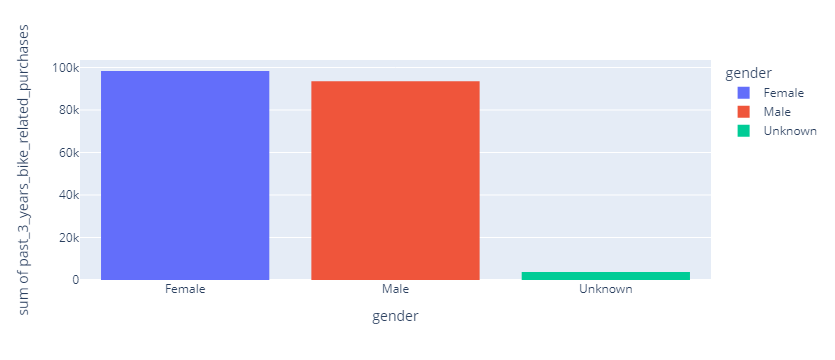

In [256]:
px.histogram(data_frame=df,x='gender',y='past_3_years_bike_related_purchases',color='gender')

In [257]:
df.wealth_segment.unique()

array(['Mass Customer', 'Affluent Customer', 'High Net Worth'],
      dtype=object)

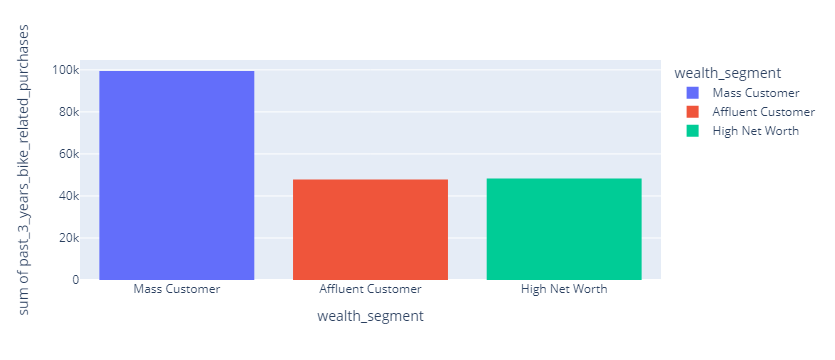

In [258]:
px.histogram(data_frame=df,x='wealth_segment',y='past_3_years_bike_related_purchases',color='wealth_segment')

In [259]:
df.job_industry_category.unique()

array(['Health', 'Financial Services', 'Property', 'IT', nan, 'Retail',
       'Argiculture', 'Manufacturing', 'Telecommunications',
       'Entertainment'], dtype=object)

In [260]:
df.loc[pd.isnull(df['job_industry_category']),'job_industry_category'] ='Unknown'

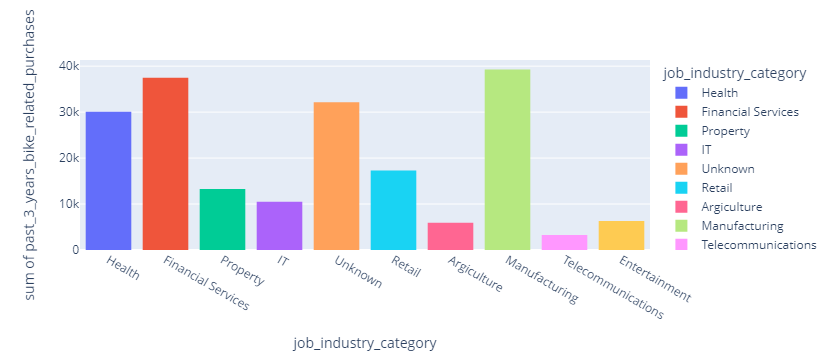

In [261]:
px.histogram(data_frame=df,
             x='job_industry_category',
             y='past_3_years_bike_related_purchases',
             color='job_industry_category')

In [262]:
df.owns_car.unique()

array(['Yes', 'No'], dtype=object)

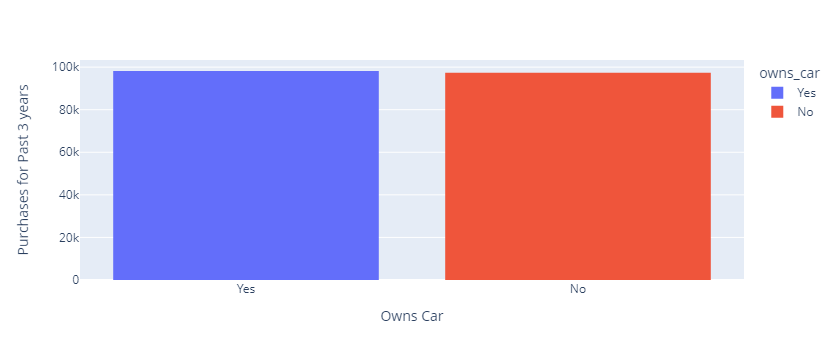

In [263]:
fig = px.histogram(data_frame=df,x='owns_car',y='past_3_years_bike_related_purchases',color='owns_car')
fig.update_layout({
    'xaxis': {'title': {'text': 'Owns Car'}},
    'yaxis': {'title': {'text': 'Purchases for Past 3 years'}}
})

fig.show()

In [264]:
df.deceased_indicator = df.deceased_indicator.map({'N':'No','Y':'Yes'})

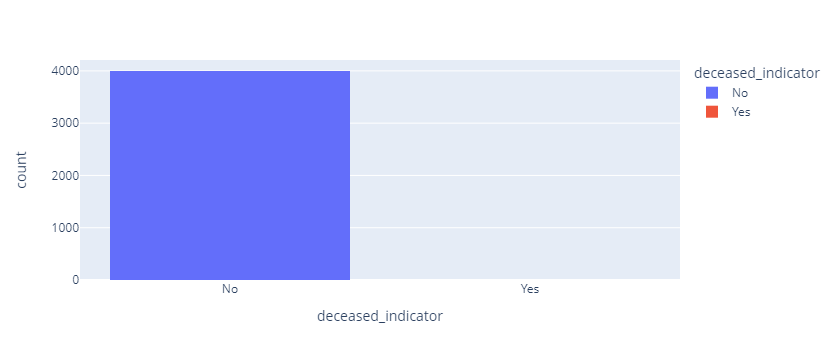

In [265]:
px.histogram(data_frame=df,x='deceased_indicator',color='deceased_indicator')

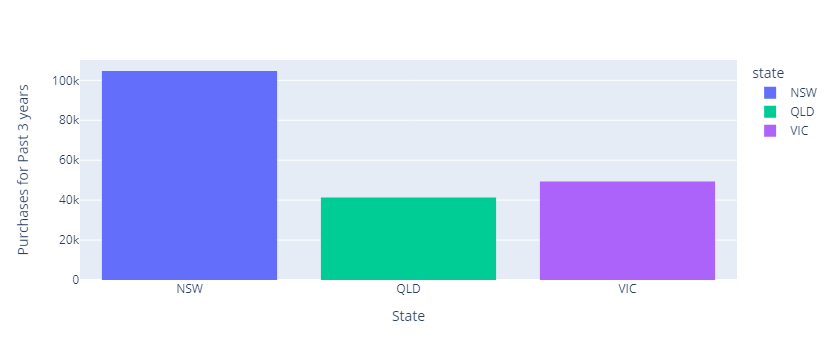

In [266]:
fig = px.histogram(data_frame=df, x='state',y='past_3_years_bike_related_purchases',color='state')
fig.update_layout({
    'xaxis': {'title': {'text': 'State'}},
    'yaxis': {'title': {'text': 'Purchases for Past 3 years'}}
})

fig.show()

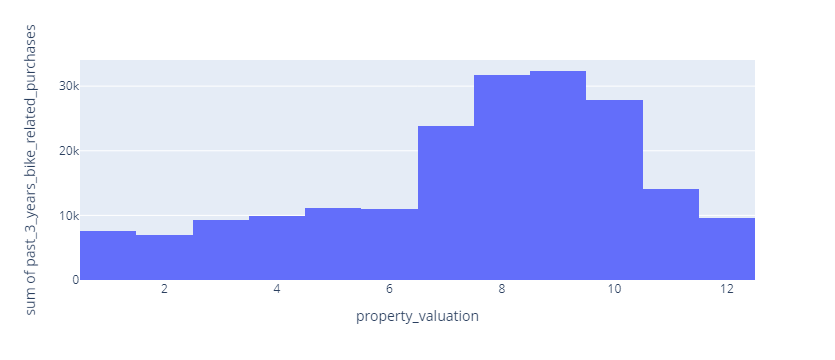

In [267]:
px.histogram(data_frame=df,x='property_valuation', y='past_3_years_bike_related_purchases')

## Feature Engineering

In [268]:
date = datetime.datetime(2018,12,30) # We use the date the data was downloaded for age calculation
df['age'] = df.DOB.apply(lambda x: precise_diff(x, date).years if not pd.isnull(x) else np.nan )
df.age.fillna(df.age.mean(),inplace=True)
df = df[~(df.age > 100)] # get ages that are not over 100
df.age.isnull().value_counts()

False    3999
Name: age, dtype: int64

In [269]:
def age_group(x):
    if x >= 18 and x <= 35:
        return 'Young Adult'
    elif x > 35 and x <= 55:
        return 'Middle Aged'
    else:
        return 'Senior Citizen'

In [270]:
df['age_group'] = df.age.apply(age_group)
df.tail(10)

,customer_id,first_name,last_name,gender,past_3_years_bike_related_purchases,DOB,job_title,job_industry_category,wealth_segment,deceased_indicator,owns_car,tenure,address,postcode,state,country,property_valuation,age,age_group
3990,3991,Rolph,Sweetnam,Male,61,1985-08-06,Chief Design Engineer,Manufacturing,Mass Customer,No,Yes,13.0,24 Scott Pass,4300.0,QLD,Australia,5.0,33.000000,Young Adult
3991,3992,Germain,Tireman,Male,99,1980-04-02,Database Administrator IV,Manufacturing,Affluent Customer,No,Yes,18.0,8 Randy Parkway,2209.0,NSW,Australia,11.0,38.000000,Middle Aged
3992,3993,Andi,Dumelow,Female,6,1974-12-05,Librarian,Entertainment,Mass Customer,No,No,10.0,681 Elmside Place,3750.0,VIC,Australia,6.0,44.000000,Middle Aged
3993,3994,Stephie,Byars,Female,5,1989-04-07,Structural Analysis Engineer,Manufacturing,Affluent Customer,No,No,12.0,2918 Summer Ridge Hill,3030.0,VIC,Australia,2.0,29.000000,Young Adult
3994,3995,Rusty,Iapico,Male,93,1975-12-12,Staff Scientist,Manufacturing,Mass Customer,No,Yes,14.0,613 Erie Lane,2088.0,NSW,Australia,12.0,43.000000,Middle Aged
3995,3996,Rosalia,Halgarth,Female,8,1975-08-09,VP Product Management,Health,Mass Customer,No,No,19.0,0 Transport Center,3977.0,VIC,Australia,6.0,43.000000,Middle Aged
3996,3997,Blanch,Nisuis,Female,87,2001-07-13,Statistician II,Manufacturing,High Net Worth,No,Yes,1.0,4 Dovetail Crossing,2350.0,NSW,Australia,2.0,17.000000,Senior Citizen
3997,3998,Sarene,Woolley,Unknown,60,NaT,Assistant Manager,IT,High Net Worth,No,No,NaN,736 Roxbury Junction,2540.0,NSW,Australia,6.0,40.967033,Middle Aged
3998,3999,Patrizius,NaN,Male,11,1973-10-24,NaN,Manufacturing,Affluent Customer,No,Yes,10.0,1482 Hauk Trail,3064.0,VIC,Australia,3.0,45.000000,Middle Aged
3999,4000,Kippy,Oldland,Male,76,1991-11-05,Software Engineer IV,Unknown,Affluent Customer,No,No,11.0,57042 Village Green Point,4511.0,QLD,Australia,6.0,27.000000,Young Adult


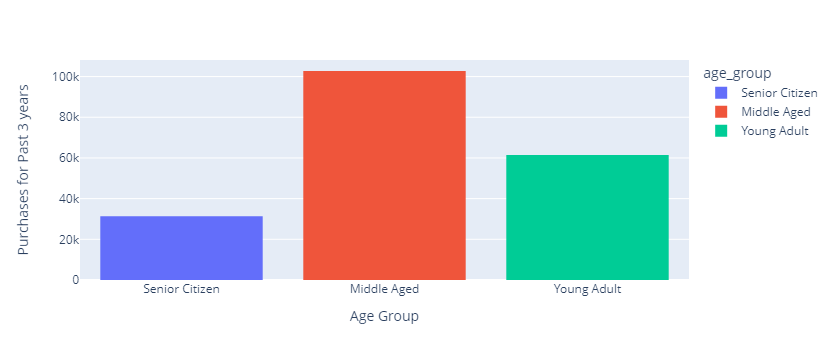

In [271]:
fig = px.histogram(data_frame=df, x='age_group',y='past_3_years_bike_related_purchases',color='age_group')
fig.update_layout({
    'xaxis': {'title': {'text': 'Age Group'}},
    'yaxis': {'title': {'text': 'Purchases for Past 3 years'}}
})

fig.show()

In [272]:
transactions.head()

,transaction_id,product_id,customer_id,transaction_date,online_order,order_status,brand,product_line,product_class,product_size,list_price,standard_cost,product_first_sold_date
0,1,2,2950,2017-02-25,0.0,Approved,Solex,Standard,medium,medium,71.49,53.62,41245.0
1,2,3,3120,2017-05-21,1.0,Approved,Trek Bicycles,Standard,medium,large,2091.47,388.92,41701.0
2,3,37,402,2017-10-16,0.0,Approved,OHM Cycles,Standard,low,medium,1793.43,248.82,36361.0
3,4,88,3135,2017-08-31,0.0,Approved,Norco Bicycles,Standard,medium,medium,1198.46,381.10,36145.0
4,5,78,787,2017-10-01,1.0,Approved,Giant Bicycles,Standard,medium,large,1765.30,709.48,42226.0


In [273]:
def online_order(x):
    online = x[1.0]
    walk_in = x[0.0]
    total = online + walk_in
    ratio = online / total
    if ratio < 0.5:
        return 'Walkin-in'
    elif ratio == 0.5 :
        return 'Both'
    else:
        return 'Online'

In [274]:
temp = pd.pivot_table(transactions,
               index=transactions['customer_id'], 
               columns='online_order',
               aggfunc='count',
               values='product_id')
temp = temp.apply(online_order,axis=1).to_frame().reset_index()
temp.rename(columns={0:'method_of_purchase'},inplace=True)
temp.head()

,customer_id,method_of_purchase
0,1,Online
1,2,Walkin-in
2,3,Walkin-in
3,4,Both
4,5,Walkin-in


In [275]:
df = df.merge(temp,on='customer_id')

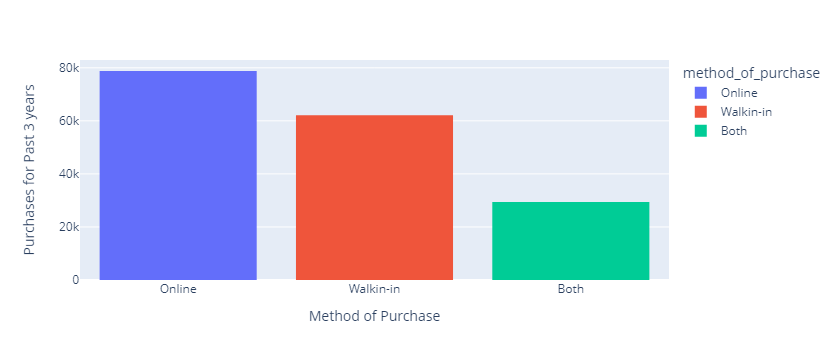

In [276]:
fig = px.histogram(data_frame=df, x='method_of_purchase',y='past_3_years_bike_related_purchases',color='method_of_purchase')
fig.update_layout({
    'xaxis': {'title': {'text': 'Method of Purchase'}},
    'yaxis': {'title': {'text': 'Purchases for Past 3 years'}}
})

fig.show()

In [277]:
transactions.to_csv('data/transactions.csv',index=False)

### Recency, Frequency & Monetary Analysis

**Calculating Recency**

In [278]:
df_recency = transactions.groupby('customer_id',as_index=False)['transaction_date'].max()
df_recency.columns = ['customer_id','last_transaction_date']
df_recency.tail()

,customer_id,last_transaction_date
3489,3497,2017-11-08
3490,3498,2017-08-25
3491,3499,2017-11-09
3492,3500,2017-08-08
3493,5034,2017-10-07


In [279]:
recent_date = df_recency.last_transaction_date.max()
df_recency['recency'] = df_recency.last_transaction_date.apply(lambda x: (recent_date - x).days)
df_recency.head()

,customer_id,last_transaction_date,recency
0,1,2017-12-23,7
1,2,2017-08-24,128
2,3,2017-09-19,102
3,4,2017-06-18,195
4,5,2017-12-14,16


**Calculating Frequency**

In [280]:
df_frequency = transactions.groupby('customer_id',as_index=False)['transaction_date'].count()
df_frequency.columns = ['customer_id','frequency']
df_frequency.tail()

,customer_id,frequency
3489,3497,3
3490,3498,6
3491,3499,7
3492,3500,6
3493,5034,3


**Calculating Monetary Value**

In [281]:
df_monetary = transactions.customer_id.to_frame()
profit = transactions.list_price - transactions.standard_cost
df_monetary['monetary'] = profit
df_monetary = df_monetary.groupby('customer_id',as_index=False)['monetary'].sum()
df_monetary.head()

,customer_id,monetary
0,1,3018.09
1,2,2226.26
2,3,3362.81
3,4,220.57
4,5,2394.94


In [282]:
df_rmf = pd.merge(df_frequency,df_monetary,how='left',on='customer_id')

In [283]:
df_rmf = df_rmf.merge(df_recency).drop(columns='last_transaction_date')
df_rmf.head()

,customer_id,frequency,monetary,recency
0,1,11,3018.09,7
1,2,3,2226.26,128
2,3,8,3362.81,102
3,4,2,220.57,195
4,5,6,2394.94,16


**Ranking the customers using recency, frequency and monetary score**

In [284]:
df_rmf['f_rank'] = df_rmf.frequency.rank(ascending=True)
df_rmf['r_rank'] = df_rmf.recency.rank(ascending=False)
df_rmf['m_rank'] = df_rmf.monetary.rank(ascending=True)
df_rmf.head()

,customer_id,frequency,monetary,recency,f_rank,r_rank,m_rank
0,1,11,3018.09,7,3417.5,3123.5,1858.0
1,2,3,2226.26,128,432.0,448.5,1188.0
2,3,8,3362.81,102,2913.0,660.0,2104.0
3,4,2,220.57,195,150.5,132.5,55.0
4,5,6,2394.94,16,1997.0,2683.0,1337.0


In [285]:
# normalize the ranks
df_rmf['f_rank_norm'] = (df_rmf.f_rank /df_rmf.f_rank.max())*100
df_rmf['r_rank_norm'] = (df_rmf.r_rank /df_rmf.r_rank.max())*100
df_rmf['m_rank_norm'] = (df_rmf.m_rank /df_rmf.m_rank.max())*100
df_rmf.head()

,customer_id,frequency,monetary,recency,f_rank,r_rank,m_rank,f_rank_norm,r_rank_norm,m_rank_norm
0,1,11,3018.09,7,3417.5,3123.5,1858.0,97.838534,89.988476,53.176875
1,2,3,2226.26,128,432.0,448.5,1188.0,12.367592,12.921348,34.001145
2,3,8,3362.81,102,2913.0,660.0,2104.0,83.395362,19.014693,60.217516
3,4,2,220.57,195,150.5,132.5,55.0,4.308617,3.817344,1.574127
4,5,6,2394.94,16,1997.0,2683.0,1337.0,57.171486,77.297609,38.265598


**Calculate the RFM Score**

In [286]:
def rfm_score(x):
    rfm = 0.15*x['r_rank_norm'] + 0.28*x['f_rank_norm'] + 0.57*x['m_rank_norm']
    return round(rfm * 0.05, 2) # We rank them on a scale of 5.

In [287]:
df_rmf['rmf_score'] = df_rmf.apply(rfm_score, axis=1)
df_rmf.head()

,customer_id,frequency,monetary,recency,f_rank,r_rank,m_rank,f_rank_norm,r_rank_norm,m_rank_norm,rmf_score
0,1,11,3018.09,7,3417.5,3123.5,1858.0,97.838534,89.988476,53.176875,3.56
1,2,3,2226.26,128,432.0,448.5,1188.0,12.367592,12.921348,34.001145,1.24
2,3,8,3362.81,102,2913.0,660.0,2104.0,83.395362,19.014693,60.217516,3.03
3,4,2,220.57,195,150.5,132.5,55.0,4.308617,3.817344,1.574127,0.13
4,5,6,2394.94,16,1997.0,2683.0,1337.0,57.171486,77.297609,38.265598,2.47


**Segmenting customers based on the rmf score**

In [288]:
def customer_category(x):
    if x < 1.6:
        return 'Lost Customer'
    elif x > 1.6 and x < 3:
        return 'Low Value Customer'
    elif x > 3 and x < 4:
        return 'Medium Value Customer'
    elif x > 4 and x < 4.5:
        return 'High Value Customer'
    else:
        return 'Top Customer'

In [289]:
df_rmf['customer_segment'] = df_rmf.rmf_score.apply(customer_category)
df_rmf.tail()

,customer_id,frequency,monetary,recency,f_rank,r_rank,m_rank,f_rank_norm,r_rank_norm,m_rank_norm,rmf_score,customer_segment
3489,3497,3,1648.320000,52,432.0,1537.0,720.0,12.367592,44.281187,20.606754,1.09,Lost Customer
3490,3498,6,3147.330000,127,1997.0,453.5,1944.0,57.171486,13.065399,55.638237,2.48,Low Value Customer
3491,3499,7,4955.250000,51,2519.5,1559.5,2972.0,72.129974,44.929415,85.060103,3.77,Medium Value Customer
3492,3500,6,1785.860000,144,1997.0,329.0,823.0,57.171486,9.478536,23.554665,1.54,Lost Customer
3493,5034,3,269.484972,84,432.0,891.0,70.0,12.367592,25.669836,2.003434,0.42,Lost Customer


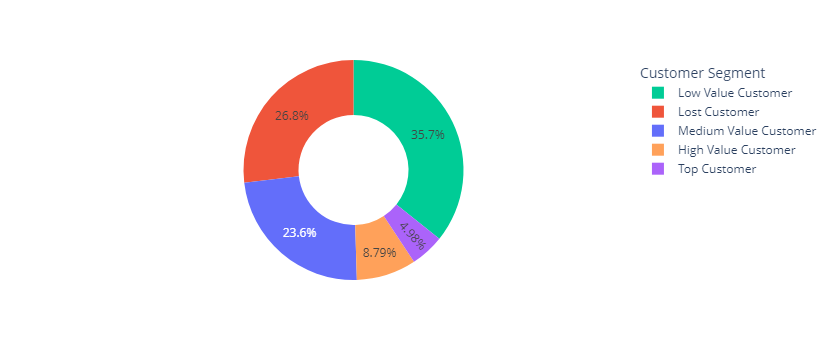

In [290]:
fig = px.pie(data_frame=df_rmf,names='customer_segment',color='customer_segment',hole=0.5)
fig.update_layout(legend={'title':'Customer Segment'})
fig.show()

In [291]:
df_rmf.to_csv('data/customer_segment.csv',index=False)

In [292]:
df_rmf = df_rmf[['customer_id', 'customer_segment']]
df_rmf.head()

df_rmf['target'] = df_rmf.customer_segment.map({'Medium Value Customer':0, 'Lost Customer':0, 'Low Value Customer':0,
       'Top Customer':1, 'High Value Customer':1})

In this examples we are going to want to target customers who fit in the **Top Customer** and **High Value Segments** so we set those to 1 and the other segments to zero.

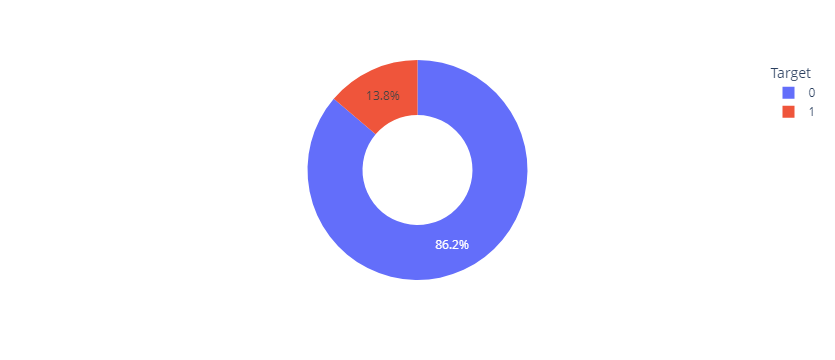

In [293]:
fig = px.pie(data_frame=df_rmf,
       names='target',
       color='target',
       hole=0.5,
       labels={'target':'Target'})
fig.update_layout(legend={'title':'Target'})
fig.show()

## Model Development

In [294]:
columns = ['gender','age_group','state','past_3_years_bike_related_purchases','property_valuation',
          'wealth_segment','age','tenure','owns_car','job_industry_category','target']

In [295]:
df = df.merge(df_rmf)

In [296]:
df[columns].tail()

,gender,age_group,state,past_3_years_bike_related_purchases,property_valuation,wealth_segment,age,tenure,owns_car,job_industry_category,target
3486,Male,Young Adult,NSW,99,9.0,Mass Customer,32.0,19.0,Yes,Manufacturing,0
3487,Female,Young Adult,VIC,73,5.0,Affluent Customer,32.0,18.0,Yes,Manufacturing,0
3488,Female,Young Adult,VIC,28,4.0,Mass Customer,23.0,5.0,No,Manufacturing,0
3489,Male,Middle Aged,QLD,29,9.0,Mass Customer,39.0,7.0,Yes,Manufacturing,0
3490,Female,Middle Aged,NSW,71,10.0,Affluent Customer,51.0,17.0,No,Entertainment,0


In [297]:
df[columns].info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3491 entries, 0 to 3490
Data columns (total 11 columns):
 #   Column                               Non-Null Count  Dtype  
---  ------                               --------------  -----  
 0   gender                               3491 non-null   object 
 1   age_group                            3491 non-null   object 
 2   state                                3487 non-null   object 
 3   past_3_years_bike_related_purchases  3491 non-null   int64  
 4   property_valuation                   3487 non-null   float64
 5   wealth_segment                       3491 non-null   object 
 6   age                                  3491 non-null   float64
 7   tenure                               3415 non-null   float64
 8   owns_car                             3491 non-null   object 
 9   job_industry_category                3491 non-null   object 
 10  target                               3491 non-null   int64  
dtypes: float64(3), int64(2), objec

In [298]:
df.state.fillna(df.state.mode().values[0],inplace=True)
df.tenure.fillna(df.tenure.mean(),inplace=True)
df.property_valuation.fillna(df.property_valuation.mean(),inplace=True)

In [299]:
df.to_csv('data/visuslization.csv')
df = df[columns]

# Split

## Preprocessing

In [300]:
df.head()

,gender,age_group,state,past_3_years_bike_related_purchases,property_valuation,wealth_segment,age,tenure,owns_car,job_industry_category,target
0,Female,Senior Citizen,NSW,93,10.000000,Mass Customer,65.0,11.0,Yes,Health,0
1,Male,Middle Aged,NSW,81,10.000000,Mass Customer,38.0,16.0,Yes,Financial Services,0
2,Male,Senior Citizen,NSW,61,7.515056,Mass Customer,64.0,15.0,Yes,Property,0
3,Male,Senior Citizen,QLD,33,9.000000,Mass Customer,57.0,7.0,No,IT,0
4,Female,Middle Aged,NSW,56,4.000000,Affluent Customer,41.0,8.0,Yes,Unknown,0


In [301]:
data = pd.get_dummies(df, columns=['job_industry_category','age_group','state','wealth_segment'])
data['gender'] = data.gender.map({'Male':0,'Female':1,'Unknown':2})
data['owns_car'] = data.owns_car.map({'No':0,'Yes':1})

In [302]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3491 entries, 0 to 3490
Data columns (total 26 columns):
 #   Column                                    Non-Null Count  Dtype  
---  ------                                    --------------  -----  
 0   gender                                    3491 non-null   int64  
 1   past_3_years_bike_related_purchases       3491 non-null   int64  
 2   property_valuation                        3491 non-null   float64
 3   age                                       3491 non-null   float64
 4   tenure                                    3491 non-null   float64
 5   owns_car                                  3491 non-null   int64  
 6   target                                    3491 non-null   int64  
 7   job_industry_category_Argiculture         3491 non-null   uint8  
 8   job_industry_category_Entertainment       3491 non-null   uint8  
 9   job_industry_category_Financial Services  3491 non-null   uint8  
 10  job_industry_category_Health        

In [303]:
X = data.drop(columns='target')
y = data['target']

In [304]:
y.value_counts()

0    3010
1     481
Name: target, dtype: int64

In [305]:
X,y = RandomOverSampler(random_state=1002).fit_resample(X,y)

In [306]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [307]:
model = LGBMClassifier(random_state=42, max_depth=17, n_estimators=500)

model.fit(X_train, y_train)
model.score(X_train, y_train), model.score(X_test, y_test)

(0.9995847176079734, 0.9518272425249169)

In [308]:
predictions = model.predict_proba(X_test)
roc_auc_score(y_test.values, predictions[:,1])

0.9915267582598222

In [309]:
pd.DataFrame(
    classification_report(
        y_test,
        model.predict(X_test),
        output_dict=True)
).to_csv('data/classification_report.csv')

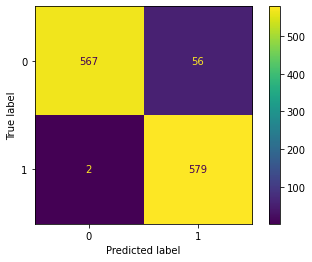

In [310]:
fig = ConfusionMatrixDisplay.from_estimator(model,X_test,y_test).figure_;
fig.savefig('data/confusion_matrix.png')

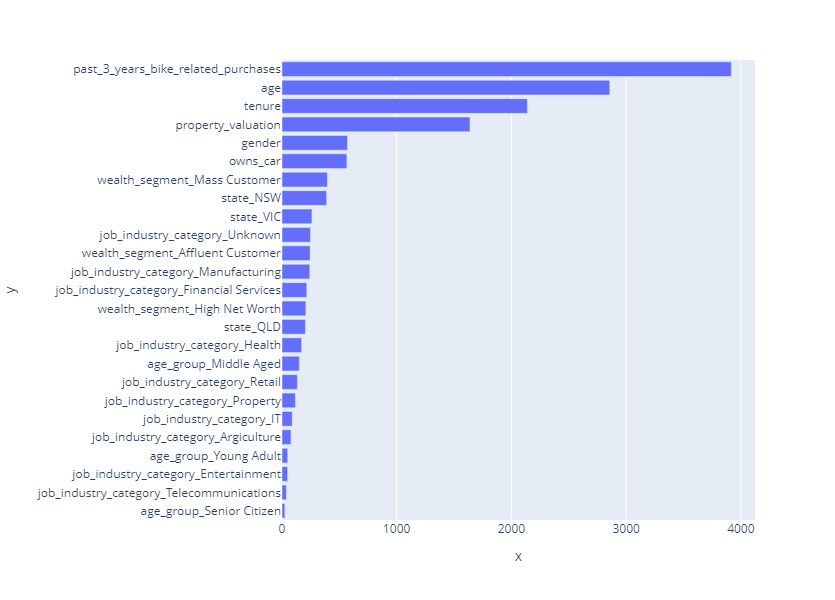

In [311]:
#Check how different features affected our model predictions.
sorted_idx = model.feature_importances_.argsort()
fig = px.bar(y=X_train.columns[sorted_idx], x=model.feature_importances_[sorted_idx])
fig.update_layout(height=600)

In [312]:
features = (pd.DataFrame(model.feature_importances_[sorted_idx],X_train.columns[sorted_idx].values).reset_index())

features.rename(columns={'index':'feature', 0:'importance'},inplace=True)

features.sort_values(by='importance', ascending=False,inplace=True)

features.importance = features.importance/100

features.to_csv('data/feature_importance.csv',index=False)

In [313]:
new_customers = df_new_customers.copy()
new_customers['age'] = new_customers.DOB.apply(lambda x: precise_diff(x, date).years if not pd.isnull(x) else np.nan )

new_customers.drop(columns=['Unnamed: 16','Unnamed: 17','Unnamed: 18','Unnamed: 19','Unnamed: 20','Rank','Value','DOB','job_title','country','postcode','address','first_name','last_name','deceased_indicator'],inplace=True)

new_customers.head()

,gender,past_3_years_bike_related_purchases,job_industry_category,wealth_segment,owns_car,tenure,state,property_valuation,age
0,Male,86,Manufacturing,Mass Customer,Yes,14,QLD,6,61.0
1,Male,69,Property,Mass Customer,No,16,NSW,11,48.0
2,Female,10,Financial Services,Affluent Customer,No,10,VIC,5,44.0
3,Female,64,Manufacturing,Affluent Customer,Yes,5,QLD,1,39.0
4,Female,34,Financial Services,Affluent Customer,No,19,NSW,9,53.0


In [314]:
new_customers.loc[pd.isnull(new_customers['job_industry_category']),'job_industry_category'] ='Unknown'
new_customers.age.fillna(new_customers.age.mean(),inplace=True)
new_customers['age_group'] = new_customers.age.apply(age_group)

new_customers = pd.get_dummies(new_customers, columns=['job_industry_category','age_group','state','wealth_segment'])
new_customers['gender'] = new_customers.gender.map({'Male':0,'Female':1,'Unknown':2})
new_customers['owns_car'] = new_customers.owns_car.map({'No':0,'Yes':1})


new_customers.head()

,gender,past_3_years_bike_related_purchases,owns_car,tenure,property_valuation,age,job_industry_category_Argiculture,job_industry_category_Entertainment,job_industry_category_Financial Services,job_industry_category_Health,...,job_industry_category_Unknown,age_group_Middle Aged,age_group_Senior Citizen,age_group_Young Adult,state_NSW,state_QLD,state_VIC,wealth_segment_Affluent Customer,wealth_segment_High Net Worth,wealth_segment_Mass Customer
0,0.0,86,1,14,6,61.0,0,0,0,0,...,0,0,1,0,0,1,0,0,0,1
1,0.0,69,0,16,11,48.0,0,0,0,0,...,0,1,0,0,1,0,0,0,0,1
2,1.0,10,0,10,5,44.0,0,0,1,0,...,0,1,0,0,0,0,1,1,0,0
3,1.0,64,1,5,1,39.0,0,0,0,0,...,0,1,0,0,0,1,0,1,0,0
4,1.0,34,0,19,9,53.0,0,0,1,0,...,0,1,0,0,1,0,0,1,0,0


In [315]:
y_pred = model.predict(new_customers)

In [316]:
new_customers['target'] = y_pred
new_customers.head()

,gender,past_3_years_bike_related_purchases,owns_car,tenure,property_valuation,age,job_industry_category_Argiculture,job_industry_category_Entertainment,job_industry_category_Financial Services,job_industry_category_Health,...,age_group_Middle Aged,age_group_Senior Citizen,age_group_Young Adult,state_NSW,state_QLD,state_VIC,wealth_segment_Affluent Customer,wealth_segment_High Net Worth,wealth_segment_Mass Customer,target
0,0.0,86,1,14,6,61.0,0,0,0,0,...,0,1,0,0,1,0,0,0,1,0
1,0.0,69,0,16,11,48.0,0,0,0,0,...,1,0,0,1,0,0,0,0,1,0
2,1.0,10,0,10,5,44.0,0,0,1,0,...,1,0,0,0,0,1,1,0,0,0
3,1.0,64,1,5,1,39.0,0,0,0,0,...,1,0,0,0,1,0,1,0,0,0
4,1.0,34,0,19,9,53.0,0,0,1,0,...,1,0,0,1,0,0,1,0,0,0


In [317]:
new_customers.target.value_counts()

0    963
1     37
Name: target, dtype: int64

In [318]:
new_customers[new_customers['target'] == 1]

,gender,past_3_years_bike_related_purchases,owns_car,tenure,property_valuation,age,job_industry_category_Argiculture,job_industry_category_Entertainment,job_industry_category_Financial Services,job_industry_category_Health,...,age_group_Middle Aged,age_group_Senior Citizen,age_group_Young Adult,state_NSW,state_QLD,state_VIC,wealth_segment_Affluent Customer,wealth_segment_High Net Worth,wealth_segment_Mass Customer,target
16,1.0,61,1,4,6,25.0,0,0,0,0,...,0,0,1,0,1,0,0,0,1,1
53,1.0,97,0,8,10,37.0,0,0,0,0,...,1,0,0,1,0,0,0,0,1,1
54,1.0,87,0,16,10,23.0,0,0,0,0,...,0,0,1,0,0,1,0,0,1,1
55,1.0,52,0,9,10,37.0,0,0,0,0,...,1,0,0,1,0,0,0,0,1,1
75,0.0,98,1,10,12,44.0,0,0,0,0,...,1,0,0,1,0,0,0,1,0,1
80,0.0,53,0,15,12,23.0,0,0,0,0,...,0,0,1,1,0,0,0,0,1,1
108,1.0,95,0,5,1,57.0,0,0,0,0,...,0,1,0,1,0,0,0,0,1,1
125,0.0,71,1,6,3,62.0,0,0,0,1,...,0,1,0,0,0,1,0,0,1,1
168,1.0,99,0,15,9,66.0,0,0,0,0,...,0,1,0,0,0,1,1,0,0,1
236,1.0,97,1,13,8,75.0,0,0,0,0,...,0,1,0,1,0,0,0,1,0,1


In [323]:
index = new_customers.index
df_new_customers.at[index,'target'] = new_customers.target

In [324]:
df.to_csv('data/distributions.csv',index=False)

In [325]:
df_new_customers.to_csv('data/new_customers.csv',index=False)
df_new_customers.head()

,first_name,last_name,gender,past_3_years_bike_related_purchases,DOB,job_title,job_industry_category,wealth_segment,deceased_indicator,owns_car,...,country,property_valuation,Unnamed: 16,Unnamed: 17,Unnamed: 18,Unnamed: 19,Unnamed: 20,Rank,Value,target
0,Chickie,Brister,Male,86,1957-07-12,General Manager,Manufacturing,Mass Customer,N,Yes,...,Australia,6,0.57,0.7125,0.890625,0.757031,1,1,1.718750,0
1,Morly,Genery,Male,69,1970-03-22,Structural Engineer,Property,Mass Customer,N,No,...,Australia,11,0.86,0.8600,1.075000,0.913750,1,1,1.718750,0
2,Ardelis,Forrester,Female,10,1974-08-28,Senior Cost Accountant,Financial Services,Affluent Customer,N,No,...,Australia,5,0.90,0.9000,0.900000,0.900000,1,1,1.718750,0
3,Lucine,Stutt,Female,64,1979-01-28,Account Representative III,Manufacturing,Affluent Customer,N,Yes,...,Australia,1,0.48,0.6000,0.600000,0.600000,4,4,1.703125,0
4,Melinda,Hadlee,Female,34,1965-09-21,Financial Analyst,Financial Services,Affluent Customer,N,No,...,Australia,9,0.90,0.9000,1.125000,1.125000,4,4,1.703125,0
